## Load and Inspect Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sktime.utils.plotting import plot_series

from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import make_scorer, mean_squared_log_error

import pickle

import warnings
# hide warnings
warnings.filterwarnings("ignore")


In [2]:
# Display all columns of a DataFrame
pd.set_option('display.max_columns', None)

## Load Data

In [3]:
# Load datasets
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_stores = pd.read_csv('../data/stores.csv')
df_oil = pd.read_csv('../data/oil.csv')
df_holidays = pd.read_csv('../data/holidays_events.csv')
df_transactions = pd.read_csv('../data/transactions.csv')

# Convert date columns to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])


## Handle missing data

In [4]:
# Handle missing oil prices using forward fill
df_oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Check if there are any remaining missing values in oil
print("Remaining missing values in oil data:")
print(df_oil.isnull().sum())

# Ensure lag and rolling feature NaNs in train data are filled (we already did this in the previous step)
df_train.fillna(0, inplace=True)

# Confirm no missing values in train data
print("Remaining missing values in train data after filling:")
print(df_train.isnull().sum())

# Since the test set doesn't have historical sales, we won't create lag/rolling features for it. 
# However, ensure there are no other missing values in the test dataset.
df_test.fillna(0, inplace=True)
print("Remaining missing values in test data after filling:")
print(df_test.isnull().sum())

# Handle the last remaining missing oil price using backward fill
df_oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verify there are no more missing values in the oil data
print("Remaining missing values in oil data after backfill:")
print(df_oil.isnull().sum())

Remaining missing values in oil data:
date          0
dcoilwtico    1
dtype: int64
Remaining missing values in train data after filling:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Remaining missing values in test data after filling:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
Remaining missing values in oil data after backfill:
date          0
dcoilwtico    0
dtype: int64


## Create Date-Based Features

In [5]:
# Feature Engineering: Date-based features
def create_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    return df

# Apply the function to both train and test datasets
df_train = create_date_features(df_train)
df_test = create_date_features(df_test)

## Add Store Features

In [6]:
# Now merge the 'cluster' information from df_stores
df_train = df_train.merge(df_stores[['store_nbr', 'cluster', 'type', 'city', 'state']], on='store_nbr', how='left')
df_test = df_test.merge(df_stores[['store_nbr', 'cluster', 'type', 'city', 'state']], on='store_nbr', how='left')

#rename type of store
df_train = df_train.rename(columns= {'type': 'type_store' })
df_test = df_test.rename(columns= {'type': 'type_store' })


## Add Holiday Feature

In [7]:
# Handle holiday data: create a flag for holidays and calculate days to next holiday
def add_holiday_features(df, df_holidays):

    # Step 1: Split df_holidays based on the locale type
    national_holidays = df_holidays[df_holidays['locale'] == 'National']
    regional_holidays = df_holidays[df_holidays['locale'] == 'Regional']
    local_holidays = df_holidays[df_holidays['locale'] == 'Local']

    # Step 2: Merge each type separately

    # 2.1 National Holidays: Merge only on date
    df_merged_national = pd.merge(df, national_holidays, on='date', how='left')

    # 2.2 Regional Holidays: Merge on date and state (locale_name corresponds to state in df_merged)
    df_merged_regional = pd.merge(
        df, 
        regional_holidays, 
        left_on=['date', 'state'], 
        right_on=['date', 'locale_name'], 
        how='left'
    )

    # 2.3 Local Holidays: Merge on date and city (locale_name corresponds to city in df_merged)
    df_merged_local = pd.merge(
        df, 
        local_holidays, 
        left_on=['date', 'city'], 
        right_on=['date', 'locale_name'], 
        how='left'
    )

    # Step 3: Combine the results

    # Start with National holidays
    df_combined = df_merged_national.copy()

    # Add columns from Regional merge, without duplicating
    df_combined = df_combined.combine_first(df_merged_regional)

    # Add columns from Local merge, without duplicating
    df_combined = df_combined.combine_first(df_merged_local)

    # Clean-up step (optional): You can drop unnecessary columns or fill NaN values
    # Drop locale_name columns if you want
    df_combined = df_combined.drop(['locale_name'], axis=1, errors='ignore')

    # Fill NaN values in the description or type columns as needed
    df_combined['description'] = df_combined['description'].fillna('No Holiday')

    #Create is_holiday column
    df_combined['is_holiday'] = df_combined['type'].notna().astype(int)

    # Show the combined dataframe
    df_merged = df_combined.copy()

    return df_merged

# Apply holiday features to train and test datasets
df_train = add_holiday_features(df_train, df_holidays)
df_test = add_holiday_features(df_test, df_holidays)


In [8]:
# Add interaction between promotion and holiday, and promotion and store cluster
df_train['promo_holiday'] = df_train['onpromotion'] * df_train['is_holiday']
df_train['store_cluster_promo'] = df_train['onpromotion'] * df_train['cluster']

df_test['promo_holiday'] = df_test['onpromotion'] * df_test['is_holiday']
df_test['store_cluster_promo'] = df_test['onpromotion'] * df_test['cluster']


## Add Promotion Features

In [9]:
# Create time since the last promotion for each store and family
def create_time_since_last_promotion(df):
    df['promo_not_active'] = (df['onpromotion'] == 0).astype(int)
    
    # Calculate the cumulative sum of days since the last promotion within each store and product family
    df['time_since_last_promo'] = df.groupby(['store_nbr', 'family'])['promo_not_active'].cumsum()
    
    # Drop the helper column 'promo_not_active'
    df.drop(columns=['promo_not_active'], inplace=True)
    
    return df

# Apply to train dataset (test set doesn't have sales history, so we skip promotions there)
df_train = create_time_since_last_promotion(df_train)


## Add Oil Features

In [10]:
# Merge oil data into the train dataset based on date
df_train = df_train.merge(df_oil[['date', 'dcoilwtico']], on='date', how='left')

# Merge transactions data into the train dataset based on date and store number
df_train = df_train.merge(df_transactions[['date', 'store_nbr', 'transactions']], on=['date', 'store_nbr'], how='left')

# Fill any remaining NaN values in dcoilwtico and transactions
df_train['dcoilwtico'].fillna(0, inplace=True)
df_train['transactions'].fillna(0, inplace=True)

# Enhancing feature engineering

##  Create Lag and Rolling Features

In [11]:
# Feature Engineering: Lag and rolling features for sales
def create_lag_features(df, lags=[1, 7, 14, 30, 60, 90]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    return df

def create_rolling_features(df, windows=[7, 14]):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window).mean())
        df[f'sales_roll_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window).std())

        df[f'sales_roll_mean_{window}'] = df[f'sales_roll_mean_{window}'].shift(1)
        df[f'sales_roll_std_{window}'] = df[f'sales_roll_std_{window}'].shift(1) 

    return df

# Apply the lag features to the train dataset
df_train = create_lag_features(df_train)
df_train = create_rolling_features(df_train)

# Since the test set lacks sales history, we can't create lag features for it directly
# Fill missing lag feature NaNs with 0
df_train.fillna(0, inplace=True)

## Feature Engineering: Seasonality and Interaction Features

In [12]:
# Cyclic features for day of week and day of year
def add_cyclic_features(df):
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    return df

# Apply to both train and test datasets
df_train = add_cyclic_features(df_train)
df_test = add_cyclic_features(df_test)

# Add interaction between promotion and holiday, and promotion and store cluster
df_train['promo_holiday'] = df_train['onpromotion'] * df_train['is_holiday']
df_train['store_cluster_promo'] = df_train['onpromotion'] * df_train['cluster']

df_test['promo_holiday'] = df_test['onpromotion'] * df_test['is_holiday']
df_test['store_cluster_promo'] = df_test['onpromotion'] * df_test['cluster']

#Drop NaN values
df_train = df_train.dropna()
df_test = df_test.dropna()

# Fill missing values resulting from lag feature creation
df_train.fillna(0, inplace=True)

In [13]:
df_train.head(2)

id       date  store_nbr      family  sales  onpromotion  year  month  day   
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  2013      1    1  \
1   1 2013-01-01          1   BABY CARE    0.0            0  2013      1    1   

   day_of_week  week_of_year  day_of_year  cluster type_store   city   
0            1             1            1       13          D  Quito  \
1            1             1            1       13          D  Quito   

       state     type    locale         description transferred  is_holiday   
0  Pichincha  Holiday  National  Primer dia del ano       False           1  \
1  Pichincha  Holiday  National  Primer dia del ano       False           1   

   promo_holiday  store_cluster_promo  time_since_last_promo  dcoilwtico   
0              0                    0                      1       93.14  \
1              0                    0                      1       93.14   

   transactions  sales_lag_1  sales_lag_7  sales_lag_14  sales_lag_30   
0           0.0          0.0          0.0           0.0           0.0  \
1           0.0          0.0          0.0           0.0           0.0   

   sales_lag_60  sales_lag_90  sales_roll_mean_7  sales_roll_std_7   
0           0.0           0.0                0.0               0.0  \
1           0.0           0.0                0.0               0.0   

   sales_roll_mean_14  sales_roll_std_14  day_of_week_sin  day_of_week_cos   
0                 0.0                0.0         0.781831          0.62349  \
1                 0.0                0.0         0.781831          0.62349   

   day_of_year_sin  day_of_year_cos  
0         0.017213         0.999852  
1         0.017213         0.999852

In [14]:
df_train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'day_of_year', 'cluster',
       'type_store', 'city', 'state', 'type', 'locale', 'description',
       'transferred', 'is_holiday', 'promo_holiday', 'store_cluster_promo',
       'time_since_last_promo', 'dcoilwtico', 'transactions', 'sales_lag_1',
       'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_lag_60',
       'sales_lag_90', 'sales_roll_mean_7', 'sales_roll_std_7',
       'sales_roll_mean_14', 'sales_roll_std_14', 'day_of_week_sin',
       'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 40 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   store_nbr              int64         
 3   family                 object        
 4   sales                  float64       
 5   onpromotion            int64         
 6   year                   int32         
 7   month                  int32         
 8   day                    int32         
 9   day_of_week            int32         
 10  week_of_year           UInt32        
 11  day_of_year            int32         
 12  cluster                int64         
 13  type_store             object        
 14  city                   object        
 15  state                  object        
 16  type                   object        
 17  locale                 object        
 18  description           

# Forecasting with XGBoost

## Train the Model

In [16]:
#Pick features to train on
features = ['onpromotion', 'transactions', 'year', 'month', 'day', 
            'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year', 'time_since_last_promo', 'is_holiday', 
            'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 
            'sales_lag_60', 'sales_lag_90',
            'promo_holiday', 'store_cluster_promo'
            ]

#Create training variables
X = df_train[features]
y = df_train['sales']

In [28]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle= False, test_size= 39*54*33)

# Create DMatrix for XGBoost
train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters with fine-tuned regularization
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,  # Equivalent to 'num_leaves' in LightGBM
    'min_child_weight': 50,  # Equivalent to 'min_data_in_leaf'
    'alpha': 0.1,  # L1 regularization, equivalent to 'lambda_l1' in LightGBM
    'lambda': 1,   # L2 regularization, equivalent to 'lambda_l2' in LightGBM
    'subsample': 0.8,  # Equivalent to 'bagging_fraction'
    'colsample_bytree': 0.9,  # Equivalent to 'feature_fraction'
    'random_state': 42
}

# Train the model with early stopping
model = xgb.train(params, train_data, num_boost_round=1000, evals=[(val_data, 'eval')],
                      early_stopping_rounds=50, verbose_eval=100)

# Predictions and RMSLE Calculation
y_train_pred = model.predict(train_data)
y_train_pred = np.clip(y_train_pred, a_min=0, a_max=None)  # Clip negative predictions

y_val_pred = model.predict(val_data)
y_val_pred = np.clip(y_val_pred, a_min=0, a_max=None)  # Clip negative predictions

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
print(10* '==')
print(f"Training RMSLE: {rmsle_train}")
print(f"Validation RMSLE: {rmsle_val}")

[0]	eval-rmse:1277.69081
[100]	eval-rmse:501.13445
[200]	eval-rmse:263.56883
[300]	eval-rmse:215.91195
[400]	eval-rmse:208.59854
[500]	eval-rmse:206.73148
[600]	eval-rmse:205.64763
[700]	eval-rmse:204.81081
[800]	eval-rmse:204.26319
[900]	eval-rmse:203.57685
[999]	eval-rmse:203.15394
Training RMSLE: 0.7173881701010771
Validation RMSLE: 0.48462396629911314


## Results

In [18]:
#Combine training results to a dataframe with TRUE value, PRED value, store and product family
def combine_results(y_train, df_train):
    y_train_all = y_train.to_frame().rename(columns= {'sales': 'true'})
    y_train_all['pred'] = y_train_pred

    y_val_all = y_val.to_frame().rename(columns= {'sales': 'true'})
    y_val_all['pred'] = y_val_pred

    y_all = pd.concat([y_train_all, y_val_all], axis= 0)
    index = df_train.index
    date = df_train.date
    y_all['id']= index
    y_all['date']= date
    y_all = y_all.reset_index()
    y_all = y_all.set_index('id')

    stores = df_train['store_nbr'].to_frame()
    family = df_train['family'].to_frame()

    y_all['store_nbr'] = stores['store_nbr']
    y_all['family'] = family['family']
    y_all = y_all.drop(columns= 'index')

    y_all = y_all.sort_index()
    y_all = y_all.set_index('date')

    return y_all

In [19]:
y_all = combine_results(y_train, df_train)

In [20]:
y_all.head(2)

true      pred  store_nbr      family
date                                             
2013-01-01   0.0  16.77268          1  AUTOMOTIVE
2013-01-01   0.0  16.77268          1   BABY CARE

In [21]:
#Create nested dic with store and product family as keys
def create_ts_dic(data):

    group = data.groupby(['store_nbr', 'family'])

    #create dic
    dic_groups = {}

    #feature engineering of data frames
    for (store, family), df in group:

        #check if store already in dic
        if store not in dic_groups:
            dic_groups[store] = {}

        #store df in nested dic
        dic_groups[store][family] = df
    
    return dic_groups

In [22]:
dic_groups = create_ts_dic(y_all)

In [23]:
#plot results for store and family

def plot_results(dic_groups, store, family, interval = 100, val_size=39):

    """Function to plot MAE values for train and val series and graph 
        with true and predicted values
    """

    df = dic_groups[store][family]
    
    df_train = df[:-val_size]
    df_val = df[-val_size:]

    train_true = df_train['true']
    train_pred = df_train['pred']
    val_true = df_val['true']
    val_pred = df_val['pred']

    # plotting for illustration
    plot_series(train_true[-interval:], train_pred[-interval:], val_true, val_pred, labels=["train TRUE", "train PRED", "val TRUE", "val PRED"])
    plt.title(f"Store-no.: {store} \n Product family: {family}")

In [24]:
# Create lists with unique store and family values
family = list(df_train.family.unique())
stores = list(df_train.store_nbr.unique())

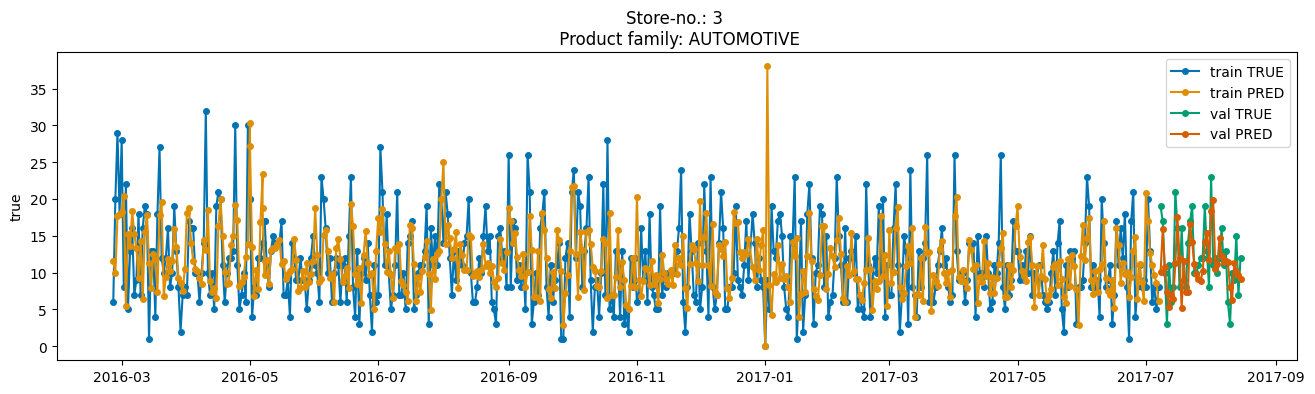

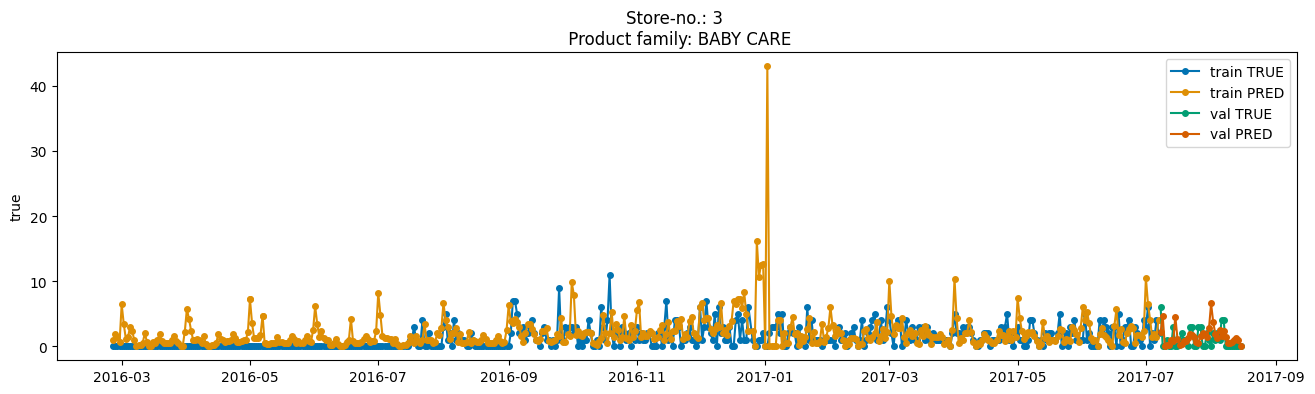

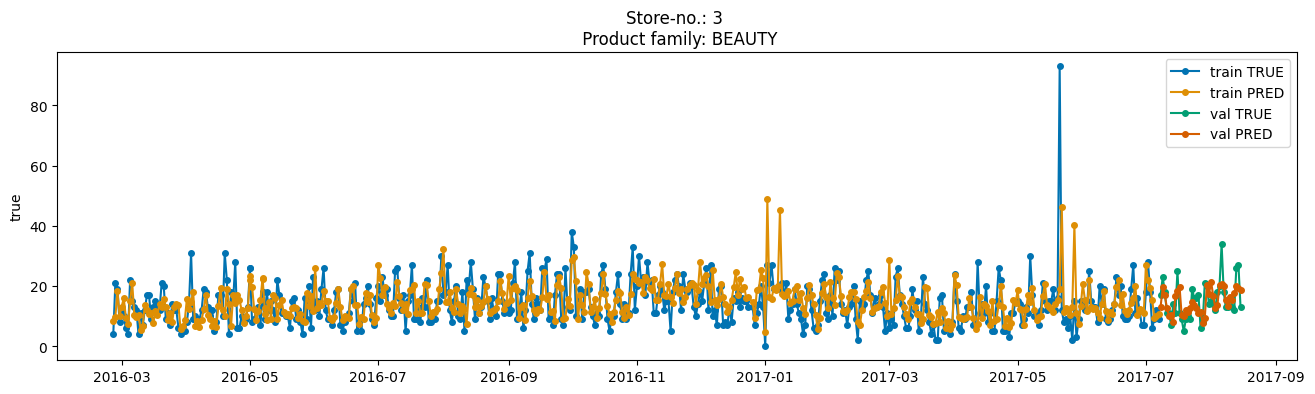

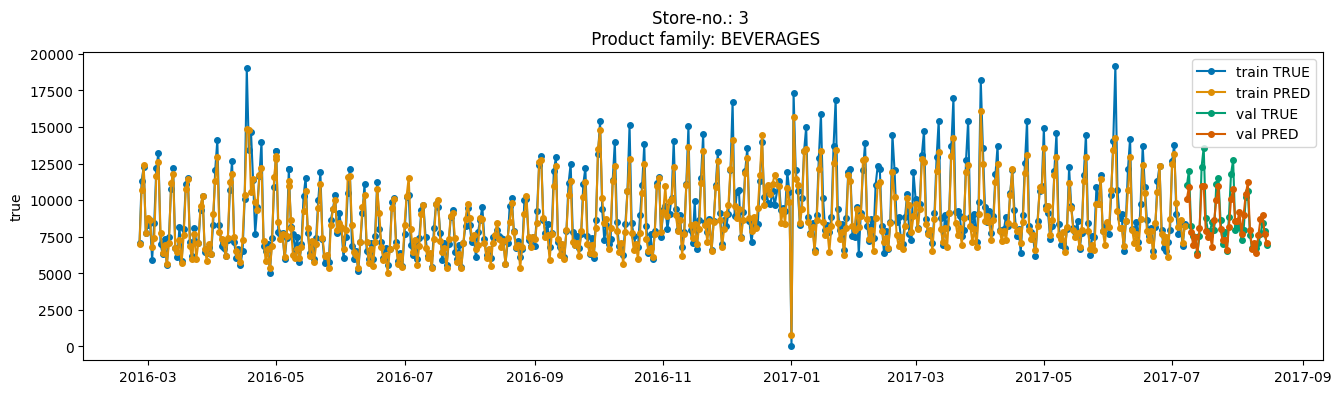

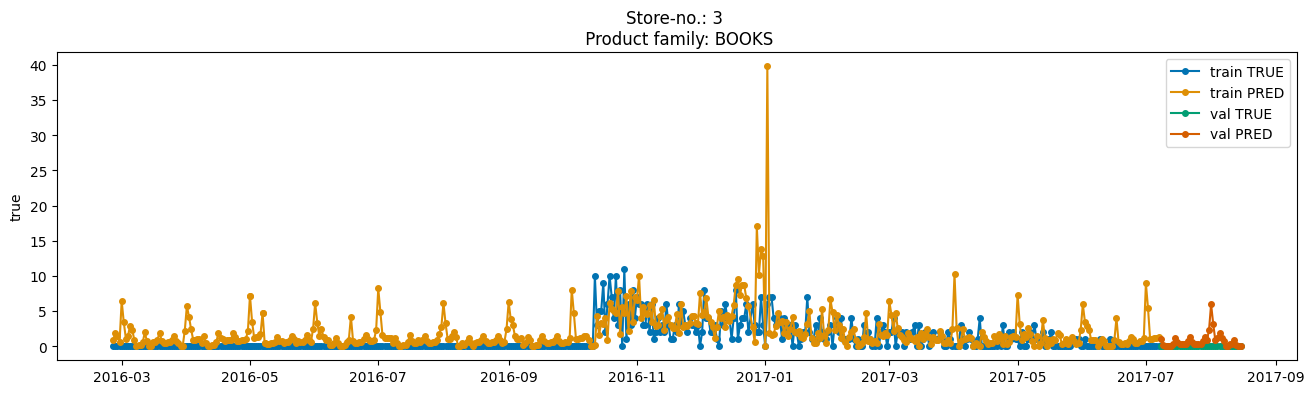

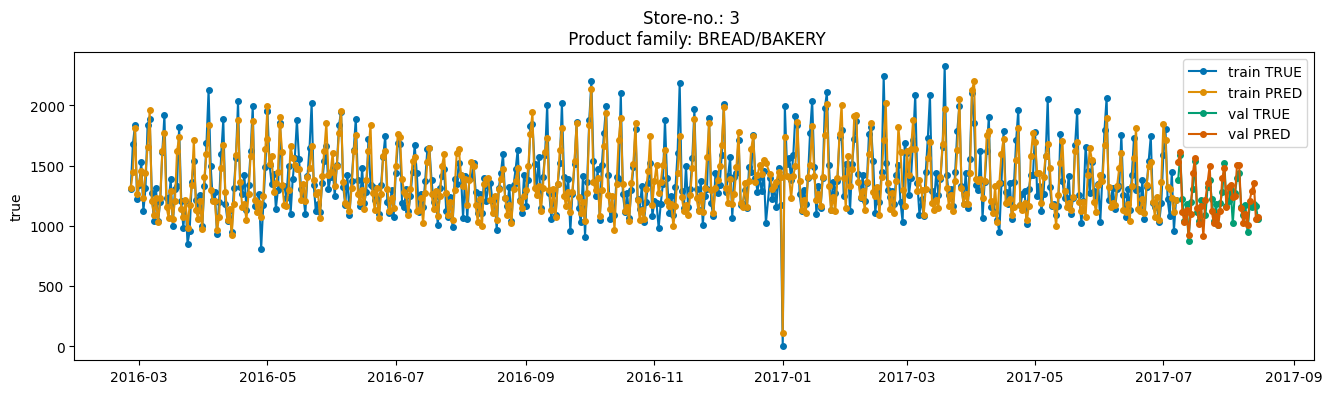

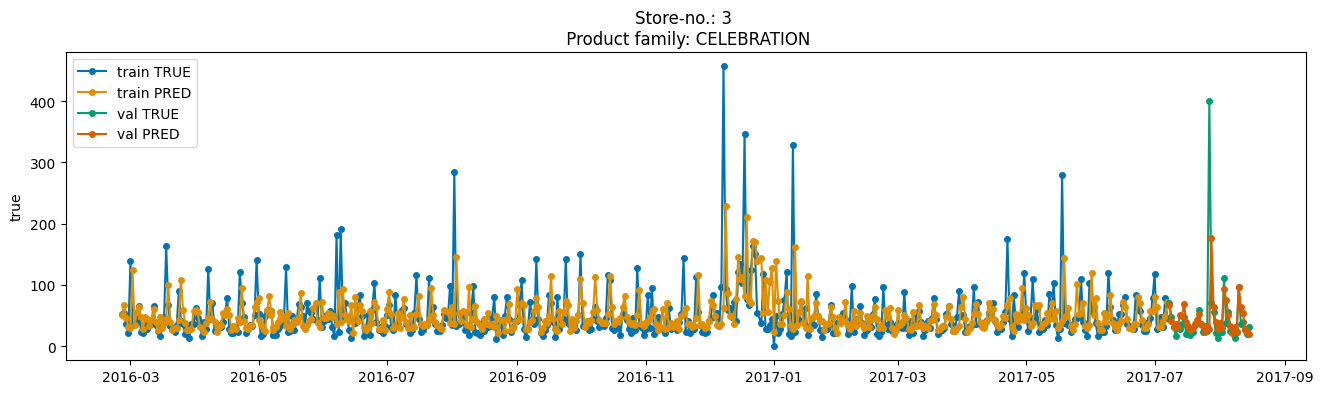

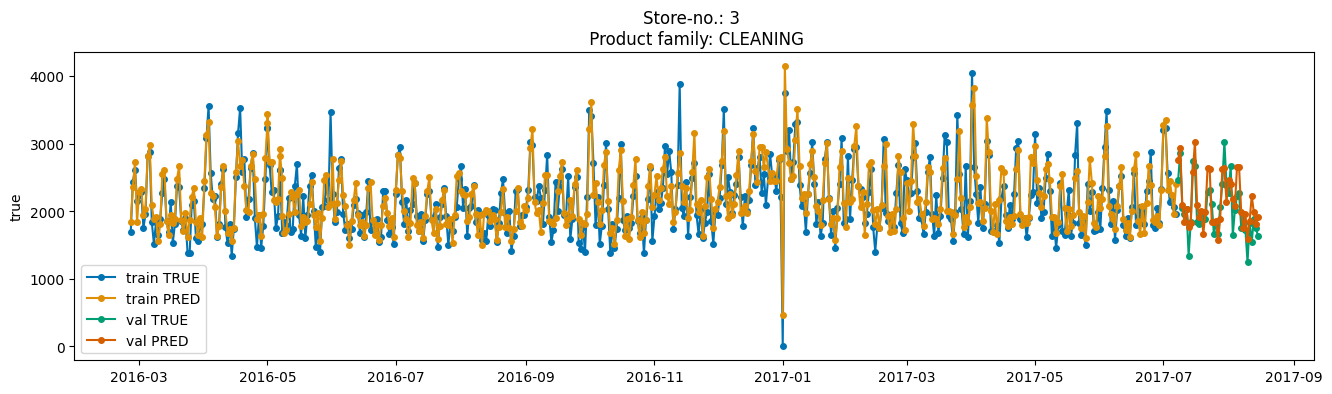

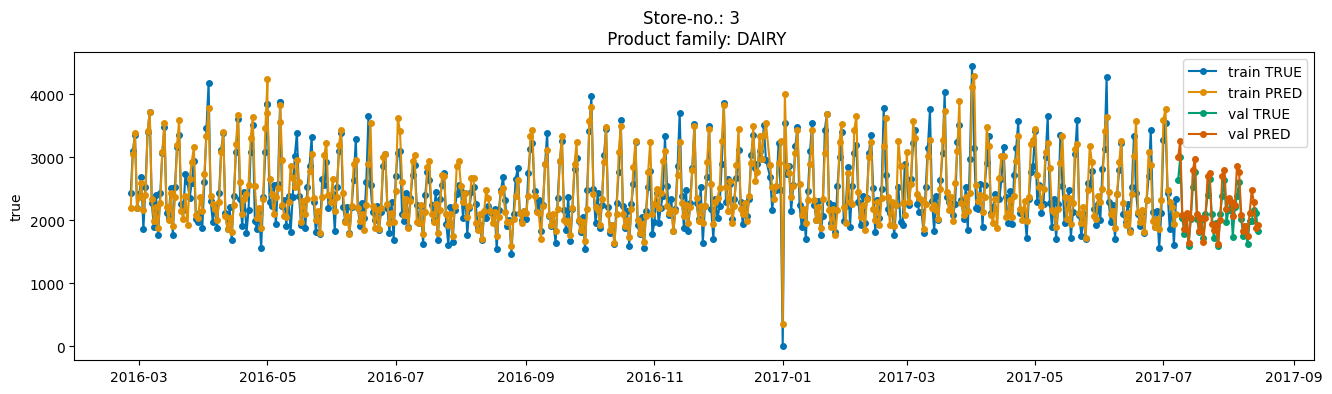

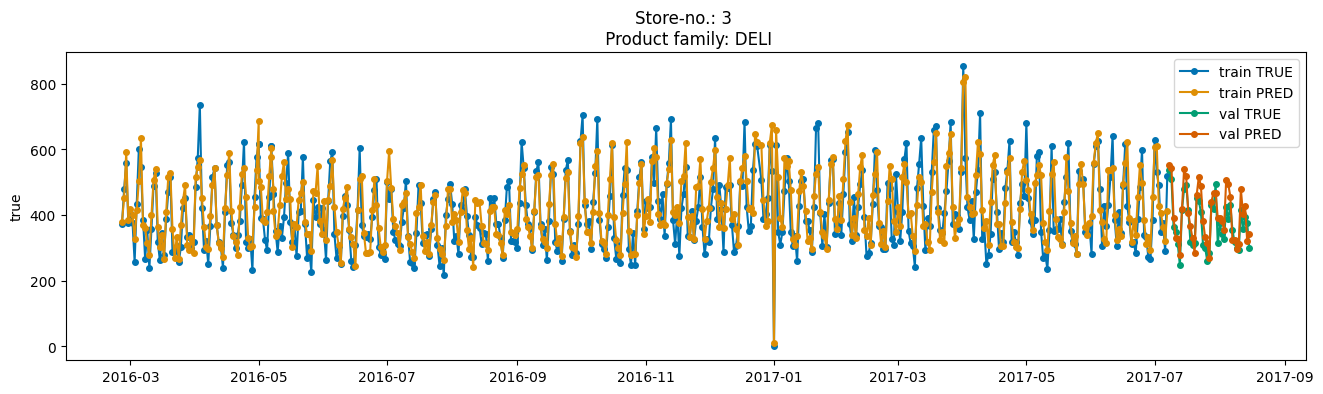

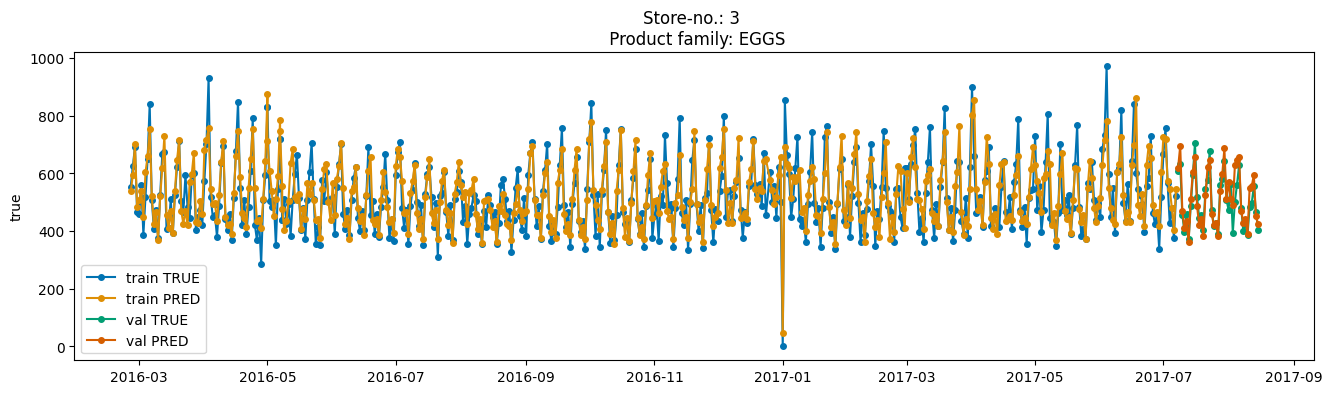

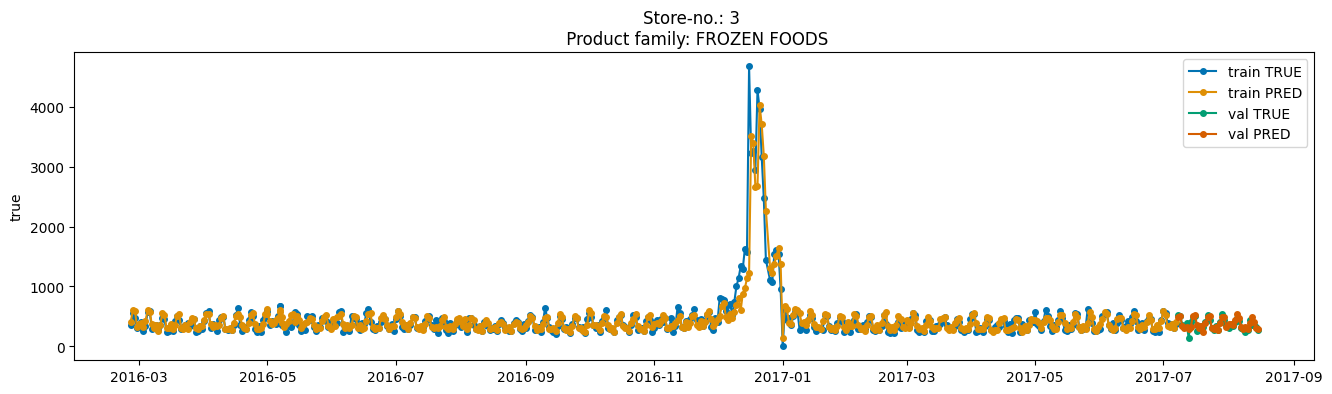

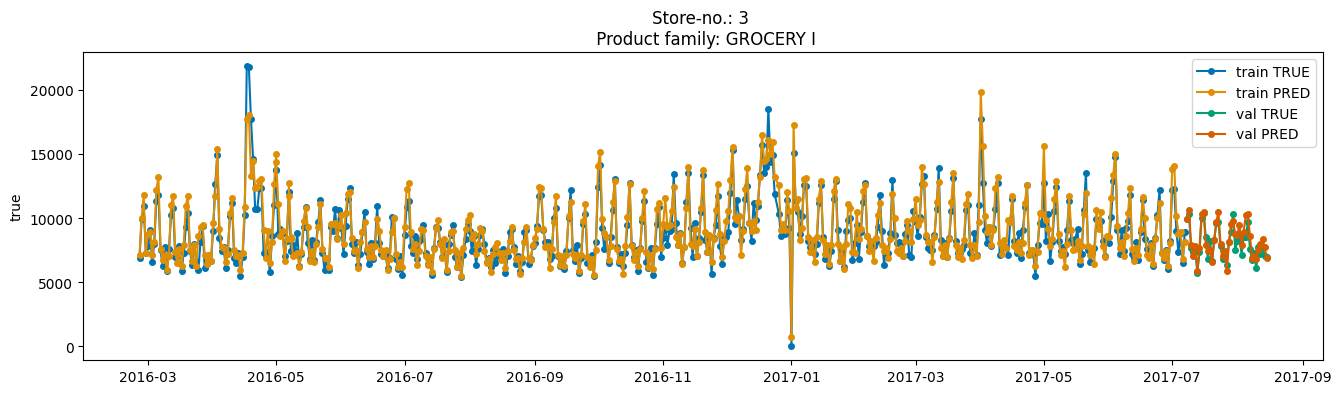

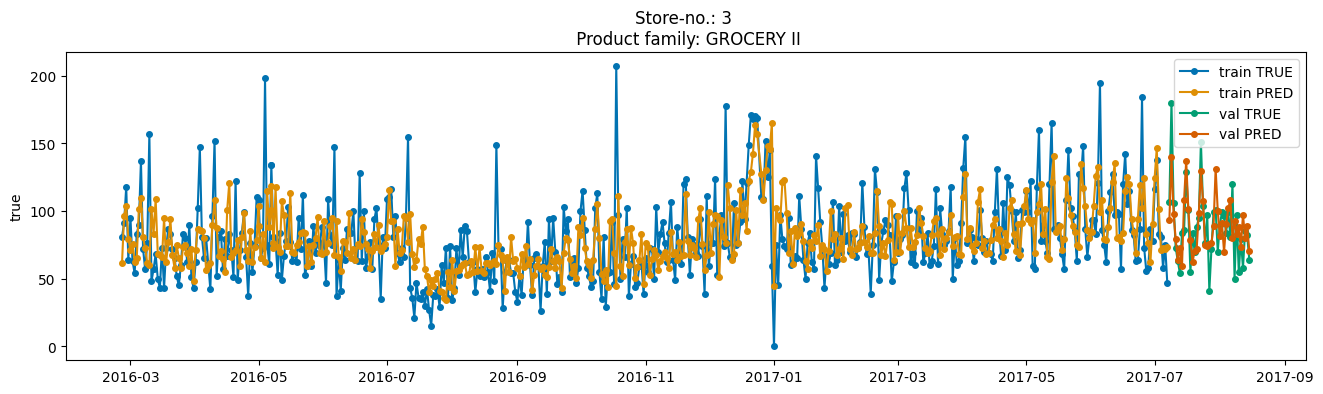

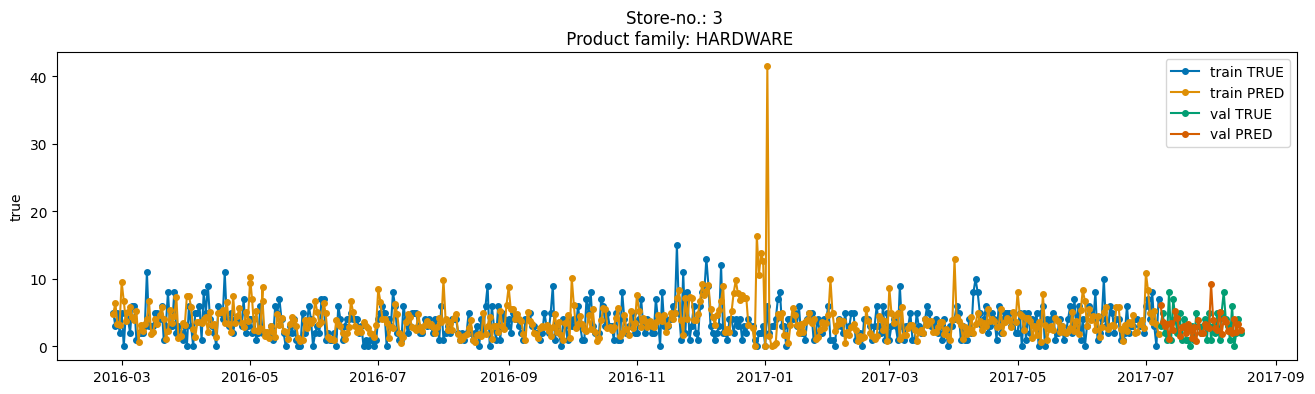

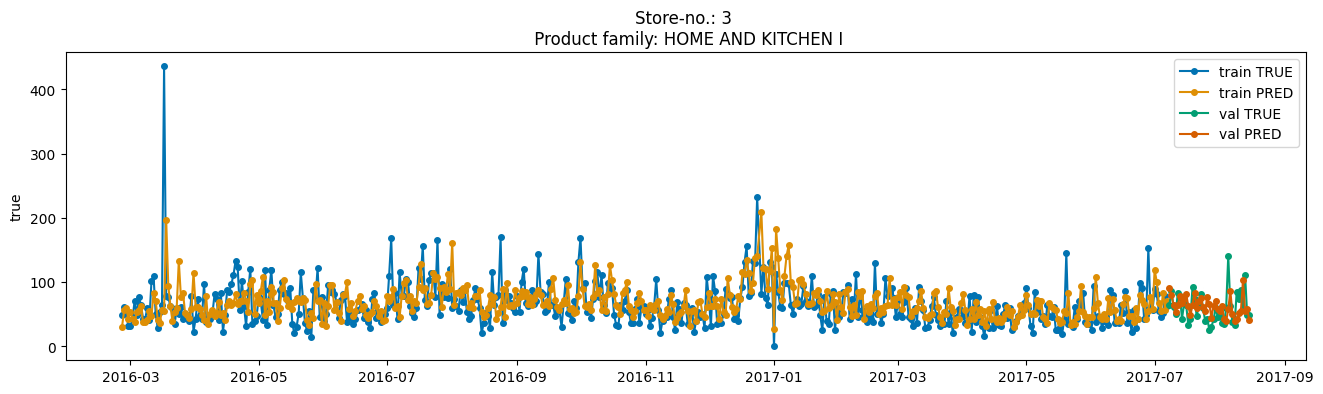

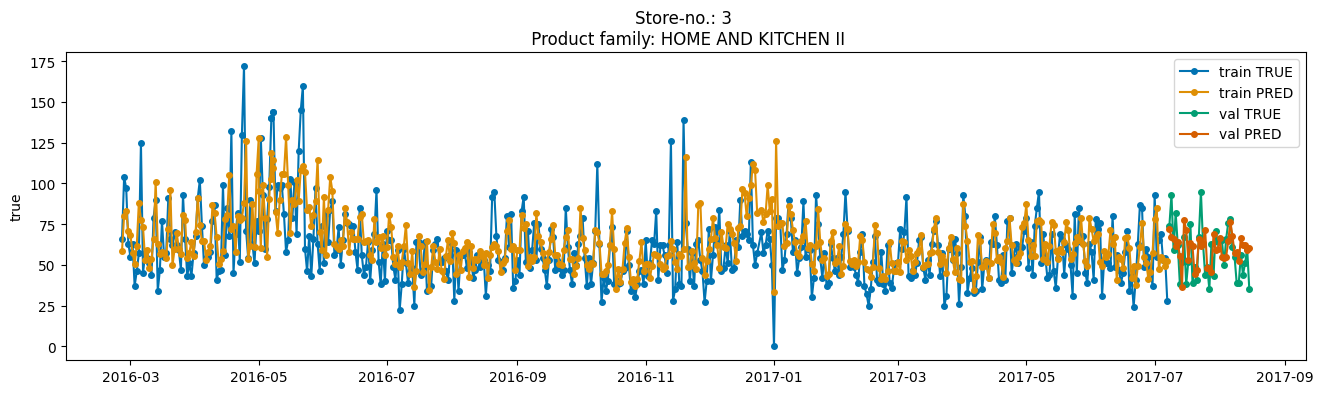

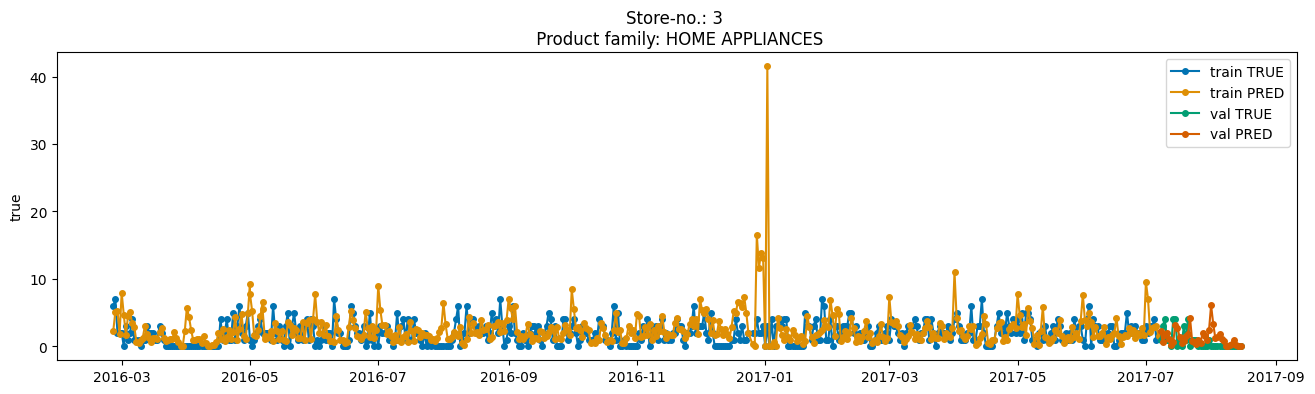

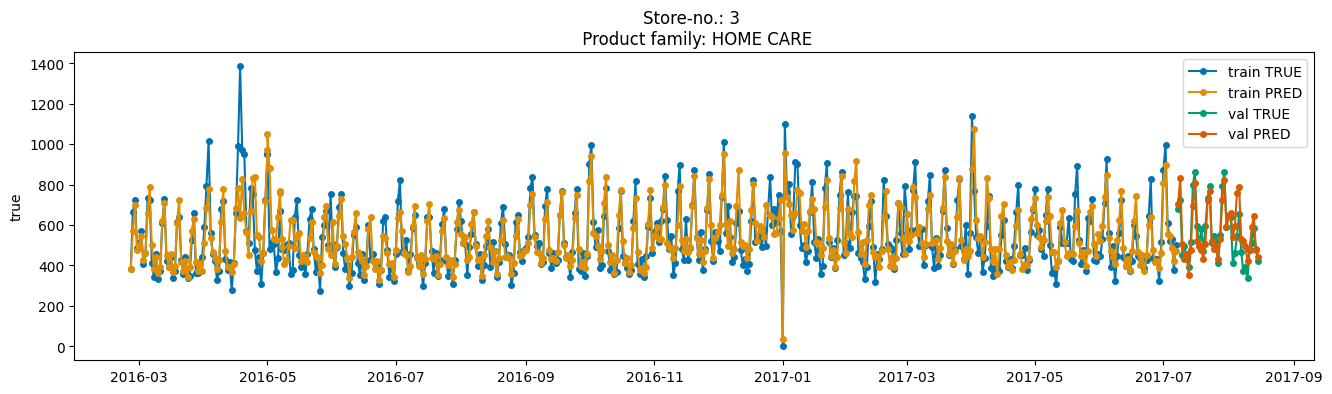

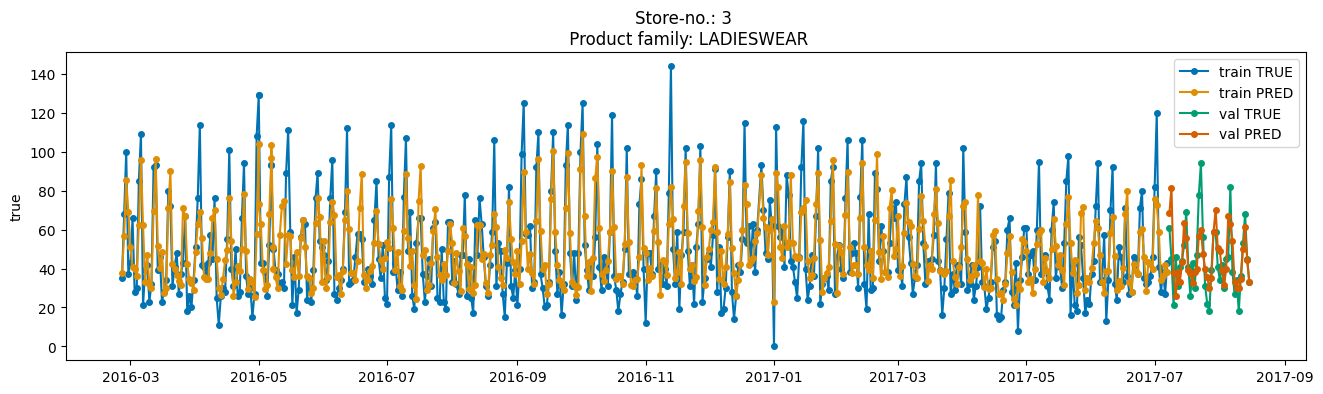

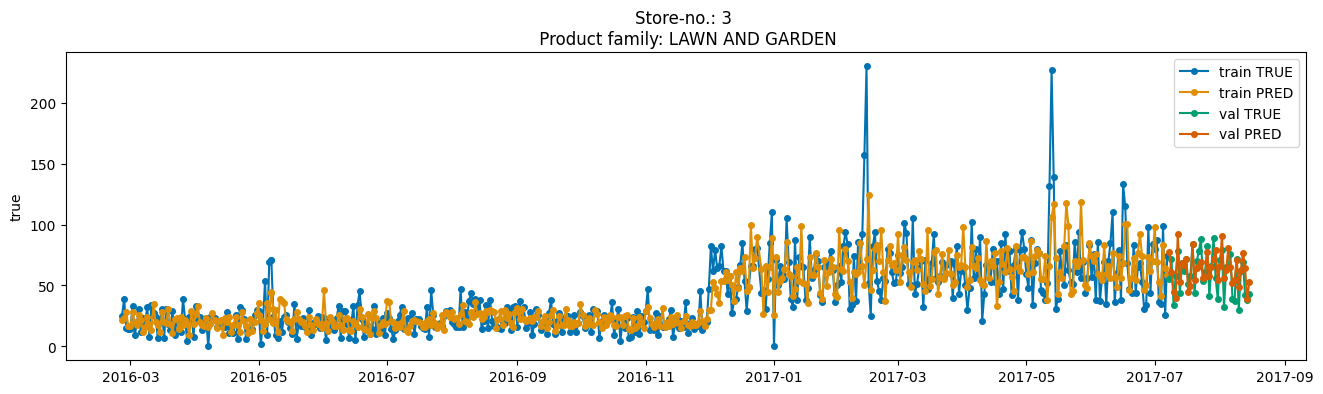

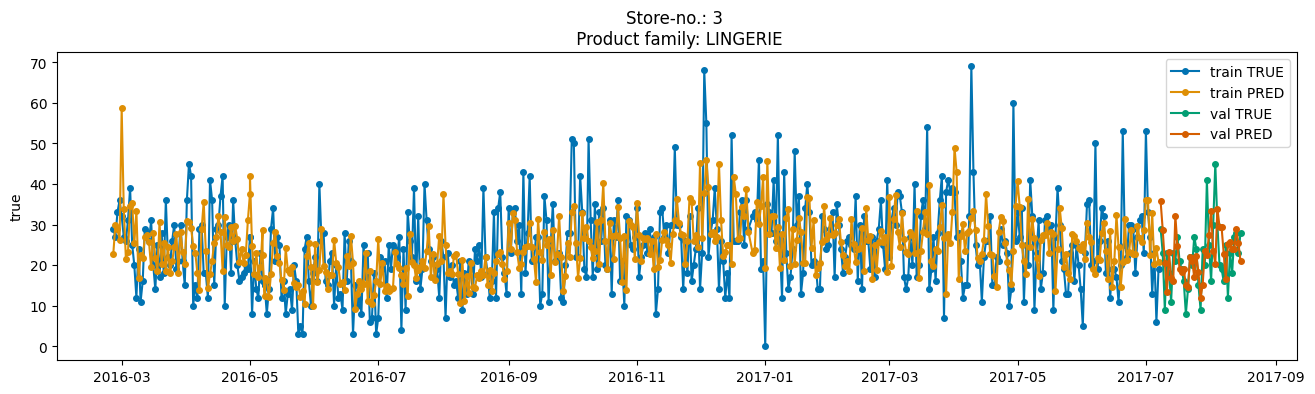

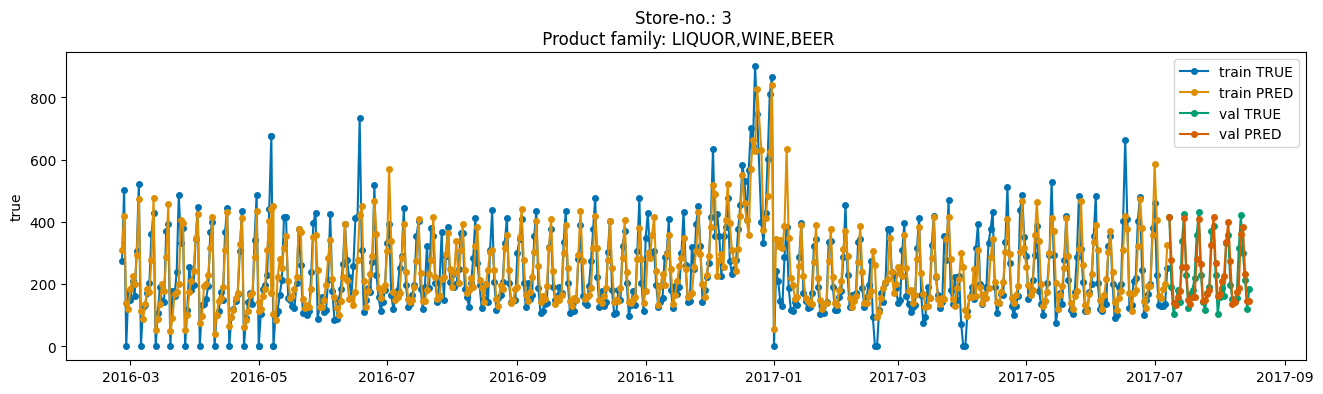

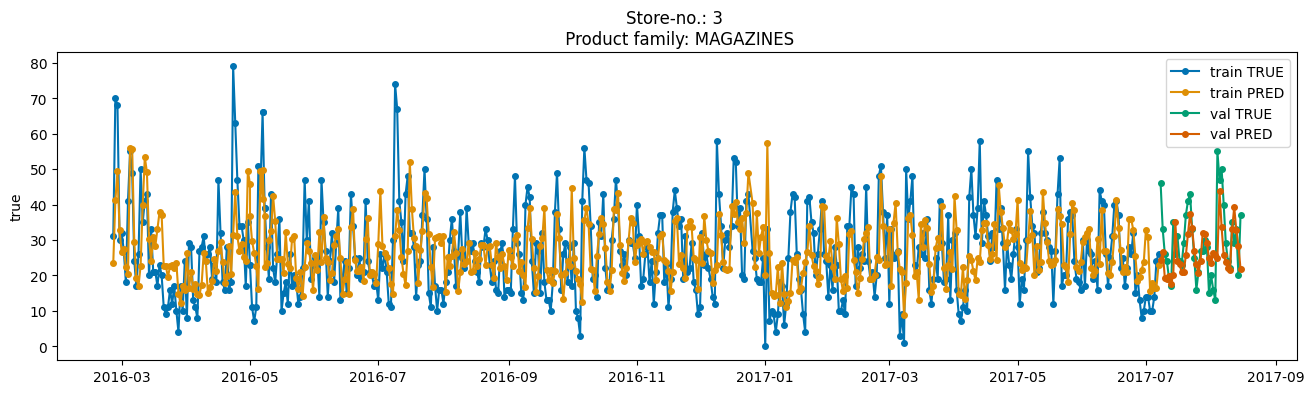

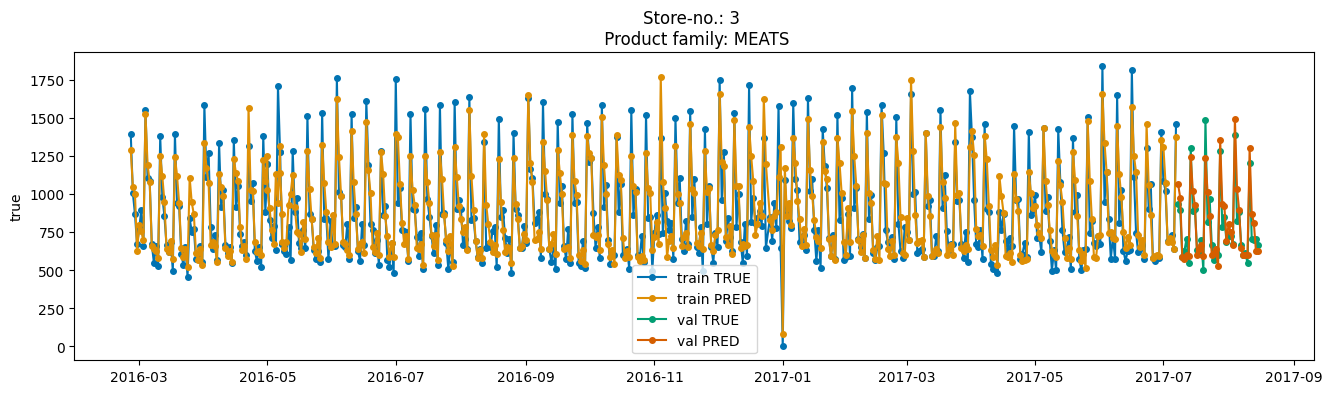

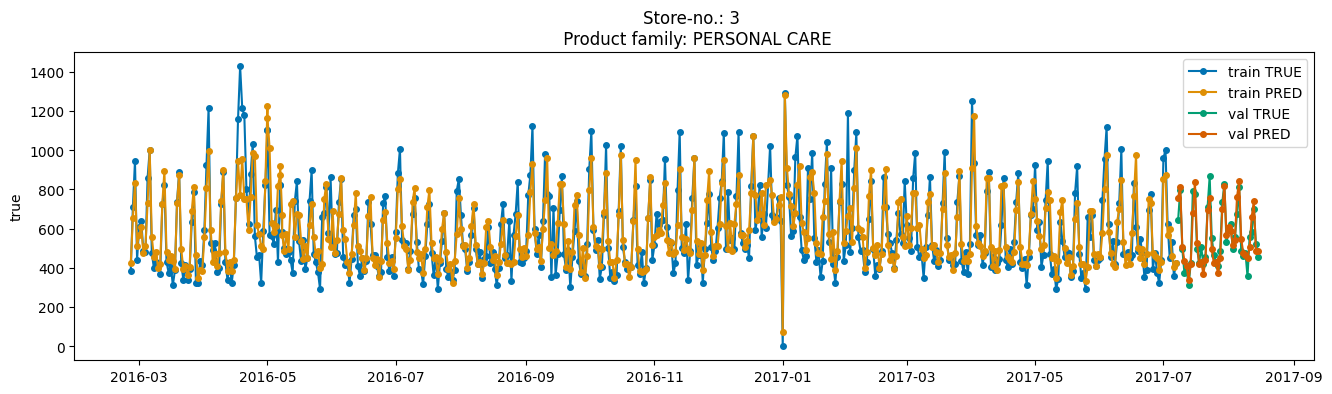

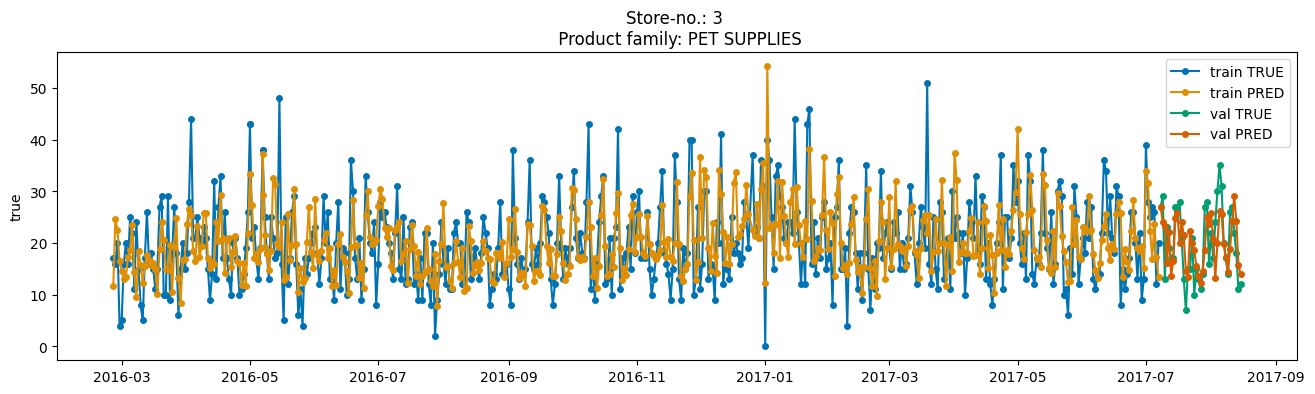

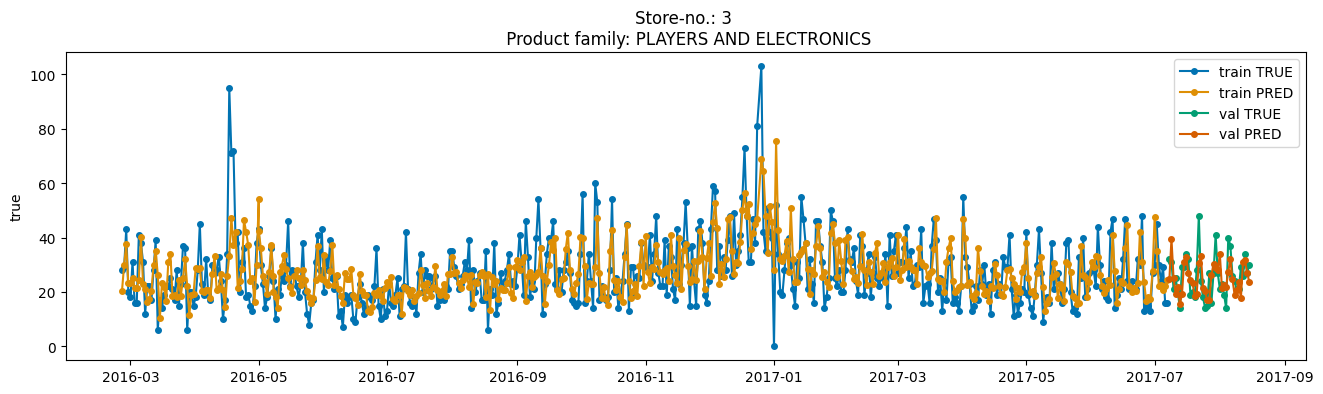

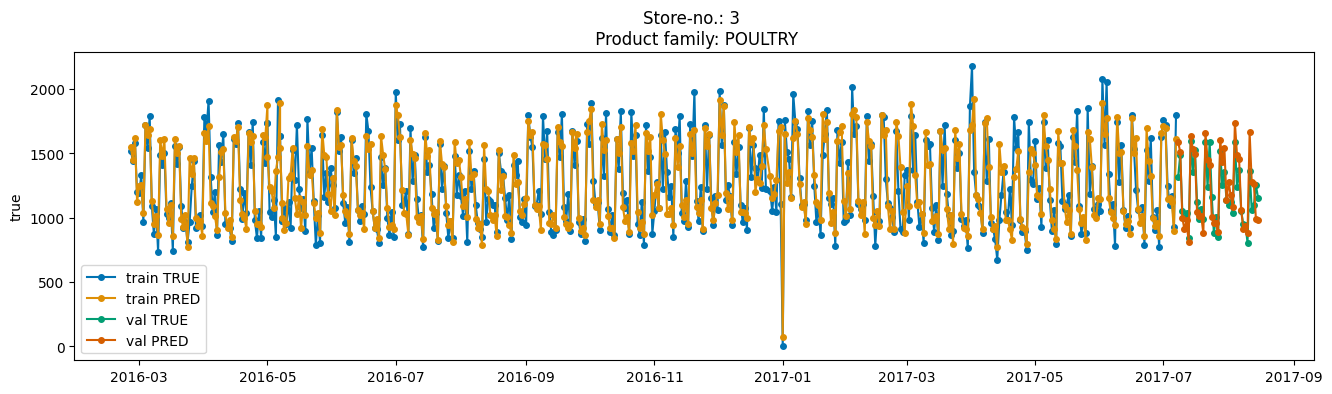

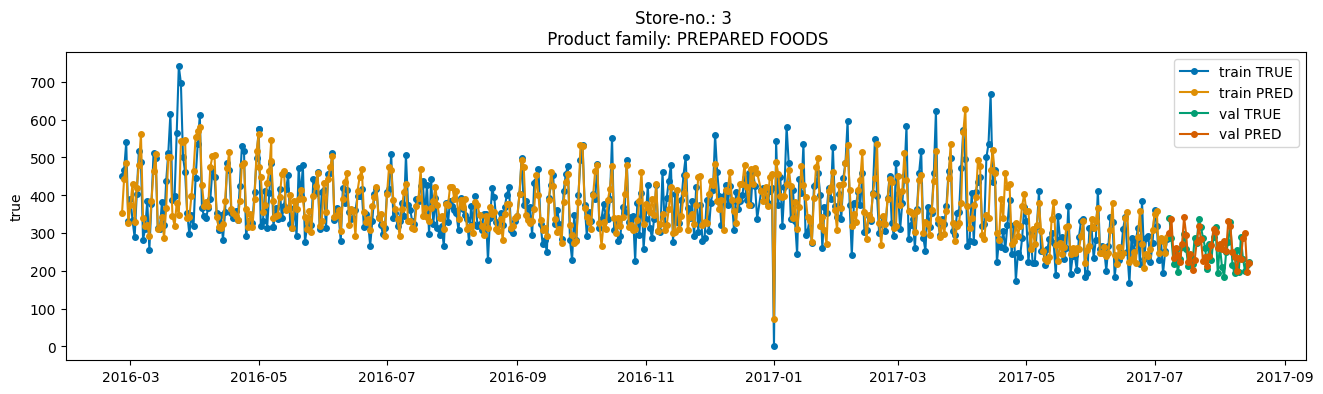

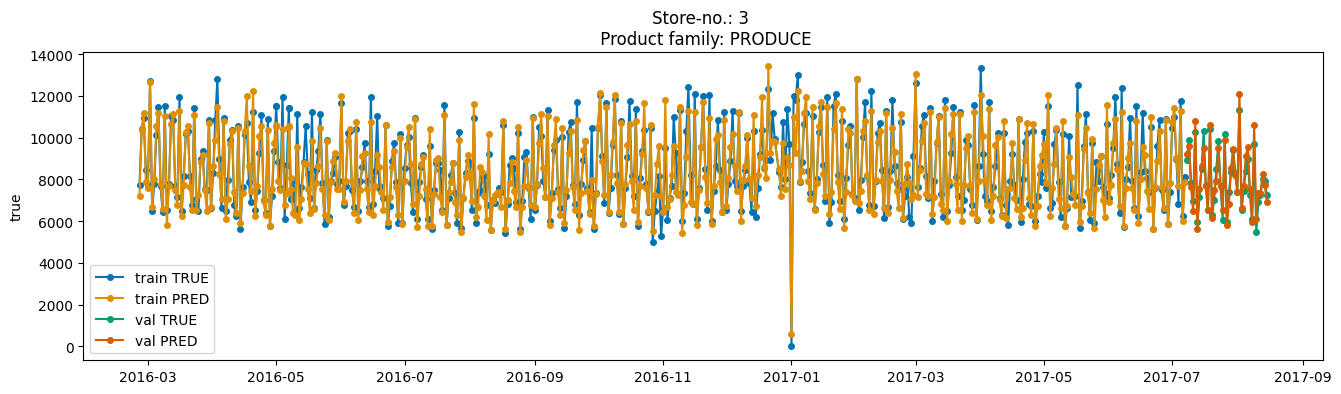

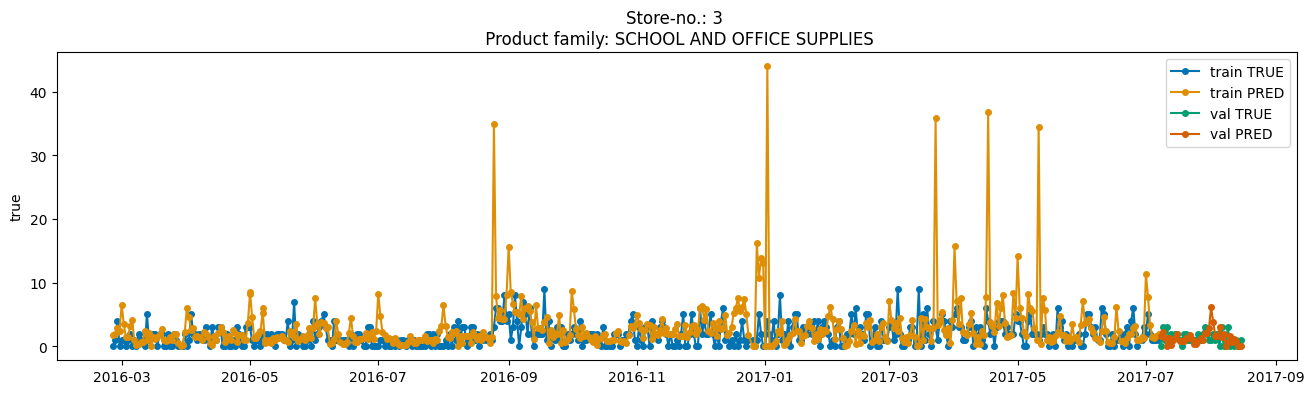

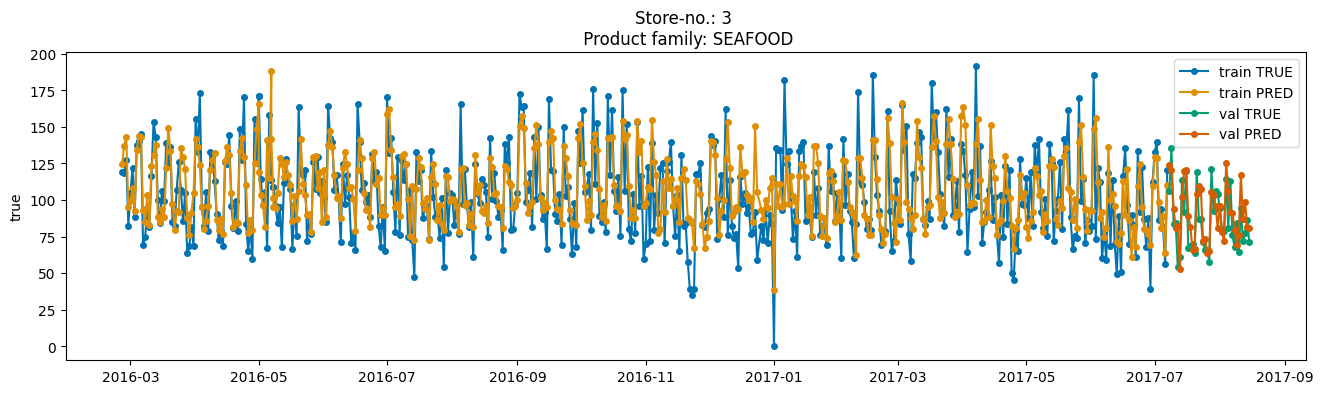

In [25]:
#Plot time series results
for i in family:
    plot_results(dic_groups, 3, i, interval= 500)

# Save the model

In [29]:
# Save the model using pickle
with open('../models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Load Model

In [30]:
# Load the model using pickle
with open('../models/xgboost_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

## Test if results are the same

In [31]:
# Predictions and RMSLE Calculation
y_train_pred = loaded_model.predict(train_data)
y_train_pred = np.clip(y_train_pred, a_min=0, a_max=None)  # Clip negative predictions

y_val_pred = loaded_model.predict(val_data)
y_val_pred = np.clip(y_val_pred, a_min=0, a_max=None)  # Clip negative predictions

rmsle_train_loaded = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_val_loaded = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
print(10* '==')
print(f"Training RMSLE: {rmsle_train}")
print(f"Validation RMSLE: {rmsle_val}")

#Gives Error if saved and loaded model and the results are different
assert rmsle_train == rmsle_train_loaded, "Train: Saved and loaded models haven't the same results"
assert rmsle_val == rmsle_val_loaded, "Val: Saved and loaded models haven't the same results"

Training RMSLE: 0.7173881701010771
Validation RMSLE: 0.48462396629911314
